In [1]:
import optax
import jax

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from dataclasses import asdict
from sklearn.model_selection import train_test_split

from src.gaussian_measure import GaussianMeasure, StochasticGaussianProcess
from src.kernels.base_kernels import GaussianKernel, ARDKernel
from src.mean_functions import Constant, MultiLayerPerceptron

jax.config.update("jax_enable_x64", True)

# Generate Random Data

In [2]:
SEED = 42
np.random.seed(SEED)
key = random.PRNGKey(SEED)
number_of_data_points = 1000
training_data_percentage = 0.9
number_of_training_data_points = jnp.ceil(
    training_data_percentage * number_of_data_points
)
sigma_true = 0.5

x = jnp.linspace(-2, 2, number_of_data_points, dtype=np.float32).reshape(-1)

key, subkey = random.split(key)


def calculate_y(x):
    return (
        2 * jnp.sin(x * (jnp.pi)) + sigma_true * random.normal(subkey, shape=x.shape)
    ).reshape(-1)

In [3]:
train_ranges = [(-2, -1), (0, 2)]
test_ranges = [(-1, 0)]
x_train = []
y_train = []
for train_range in train_ranges:
    x_train.extend(x[(train_range[0] <= x) & (x <= train_range[1])])

x_test = []
y_test = []
for test_range in test_ranges:
    x_test.extend(x[(test_range[0] <= x) & (x <= test_range[1])])
x = x.reshape(-1, 1)
x_train = jnp.array(x_train).reshape(-1, 1)
x_test = jnp.array(x_test).reshape(-1, 1)
y_train = calculate_y(x_train)
y_test = calculate_y(x_test)

In [4]:
number_of_inducing_points = int(2 * np.sqrt(number_of_data_points))

key, subkey = random.split(key)
inducing_indices = random.choice(
    key,
    a=jnp.arange(number_of_training_data_points).astype(int),
    shape=(number_of_inducing_points,),
    replace=False,
)
x_inducing, y_inducing = x_train[inducing_indices], y_train[inducing_indices]

# Gaussian Process

In [5]:
kernel = ARDKernel()
kernel_parameters = kernel.Parameters(
    log_sigma=jnp.log(5),
    log_alpha=jnp.log(0.5 * jnp.ones(x.shape[1])),
)
constant_mean_function = Constant()

gaussian_process = GaussianMeasure(x_inducing, y_inducing, kernel)
gaussian_process_parameters = GaussianMeasure.Parameters(
    log_sigma=jnp.log(2.0),
    kernel=kernel_parameters,
    mean=None,
)

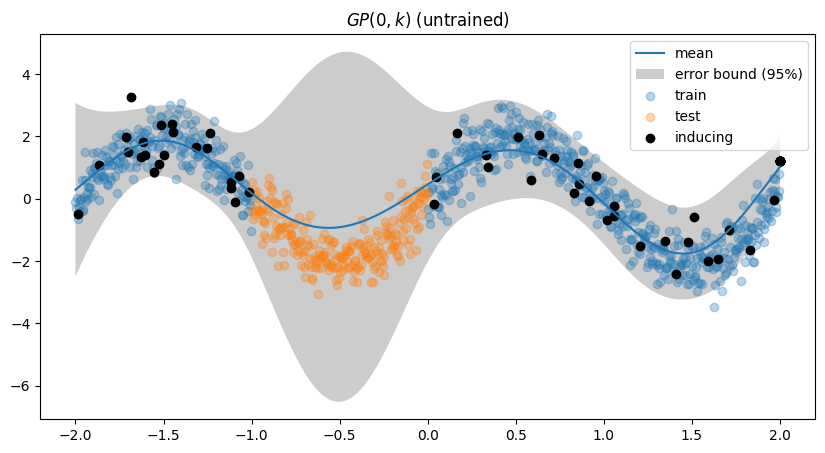

In [6]:
mean, covariance = gaussian_process.mean_and_covariance(
    x, **asdict(gaussian_process_parameters)
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$GP(0, k)$ (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

In [7]:
learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
number_of_iterations = 500
gaussian_process_parameters = gaussian_process.train(
    optimizer, number_of_iterations, **asdict(gaussian_process_parameters)
)

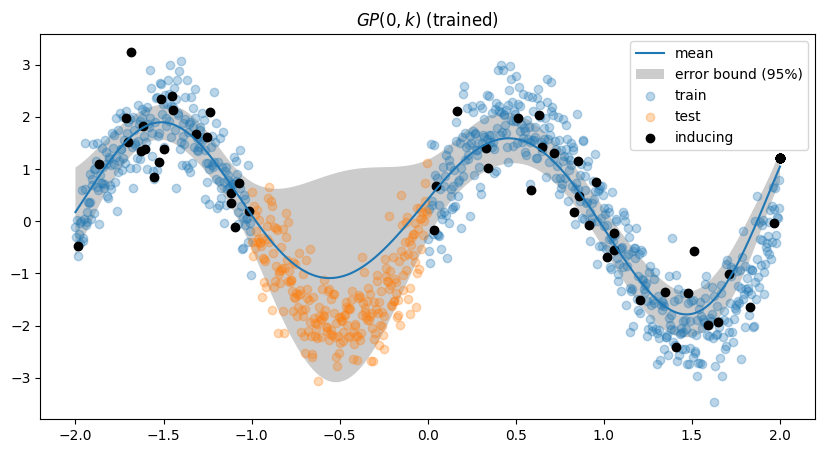

In [8]:
mean, covariance = gaussian_process.mean_and_covariance(
    x, **asdict(gaussian_process_parameters)
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$GP(0, k)$ (trained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Variational GP

In [9]:
from src.kernels.variational_kernels import VariationalKernel

In [10]:
variational_kernel = VariationalKernel(
    base_kernel=kernel, inducing_points=x_inducing, regularisation=1e-5
)
variational_kernel_parameters = VariationalKernel.Parameters(
    log_sigma=jnp.log(300),
    base_kernel_parameters=kernel_parameters,
)

In [11]:
gram = variational_kernel.kernel(variational_kernel_parameters, x)

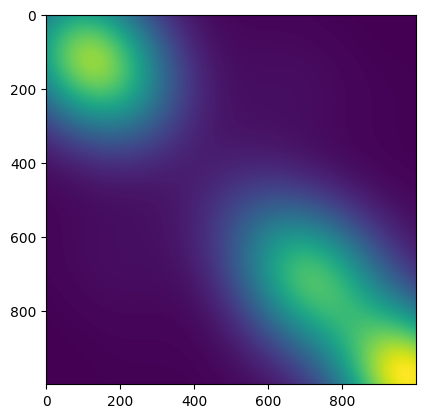

In [12]:
plt.imshow(gram)

In [13]:
neural_network = MultiLayerPerceptron([1, 10, 10, 1])
key, subkey = jax.random.split(key)
neural_network_parameters = neural_network.init(subkey, x_train)

In [14]:
svgp = StochasticGaussianProcess(x_train, y_train, variational_kernel, neural_network)
key, subkey = jax.random.split(key)

svgp_parameters = StochasticGaussianProcess.Parameters(
    log_sigma=gaussian_process_parameters.log_sigma,
    kernel=variational_kernel_parameters,
    mean=neural_network_parameters,
    beta=0.1 * random.normal(subkey, shape=(number_of_inducing_points, 1)),
)

# GWI

In [15]:
from src.dissimilarity_metrics import (
    GaussianWassersteinDistance,
    GaussianWassersteinDistanceFrozenParameters,
    GaussianWassersteinDistanceVariableParameters,
)

In [16]:
gaussian_wasserstein_distance_frozen_parameters = (
    GaussianWassersteinDistanceFrozenParameters(
        gaussian_measure_p_mean=gaussian_process_parameters.mean,
        gaussian_measure_p_kernel=gaussian_process_parameters.kernel,
        gaussian_measure_p_log_sigma=gaussian_process_parameters.log_sigma,
    )
)
gaussian_wasserstein_distance_variable_parameters = (
    GaussianWassersteinDistanceVariableParameters(
        gaussian_measure_q_kernel=svgp_parameters.kernel,
        gaussian_measure_q_mean=svgp_parameters.mean,
        gaussian_measure_q_beta=svgp_parameters.beta,
    )
)
gaussian_wasserstein_distance = GaussianWassersteinDistance(
    gaussian_measure_p=gaussian_process,
    gaussian_measure_q=svgp,
)

In [17]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
number_of_iterations = 1000

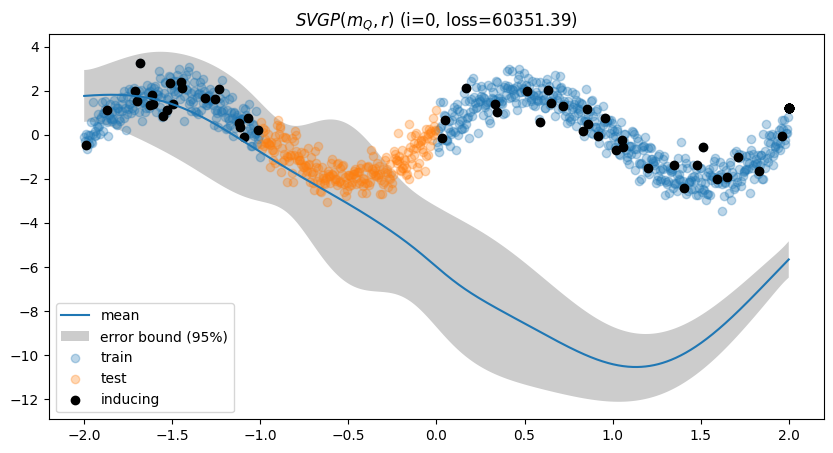

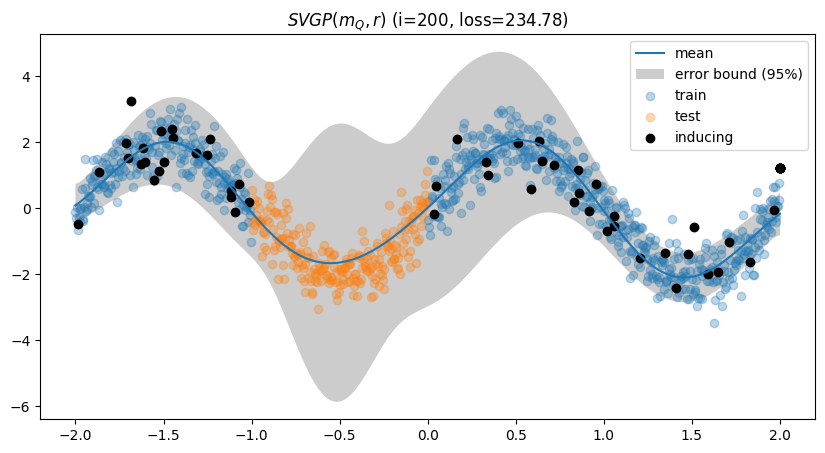

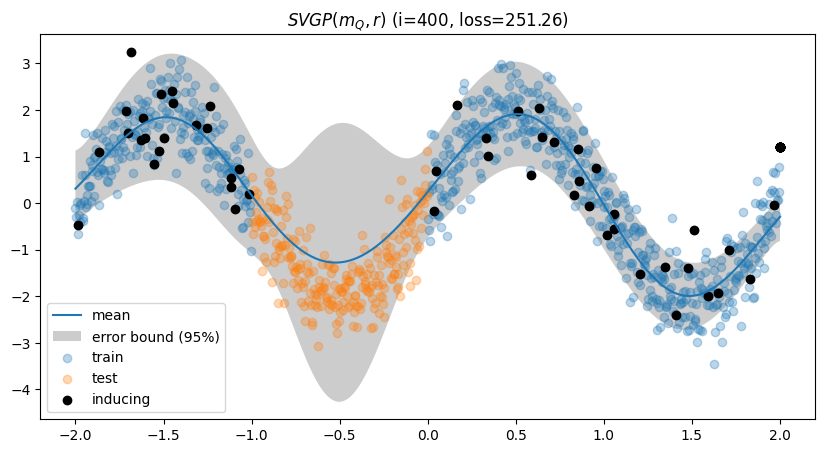

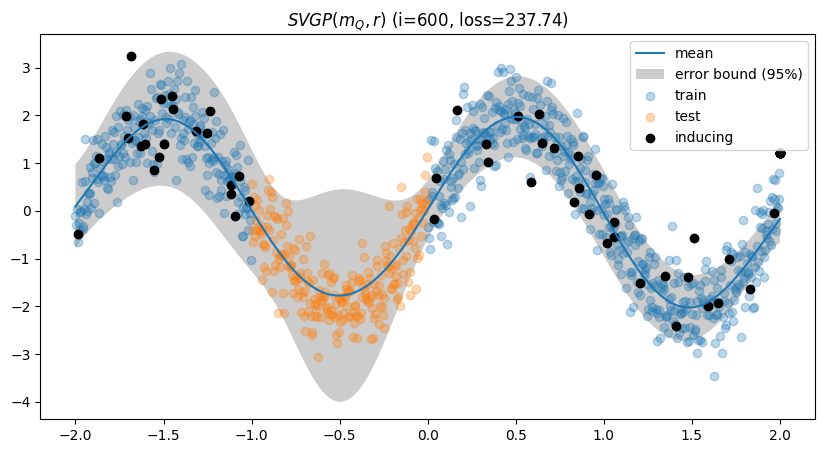

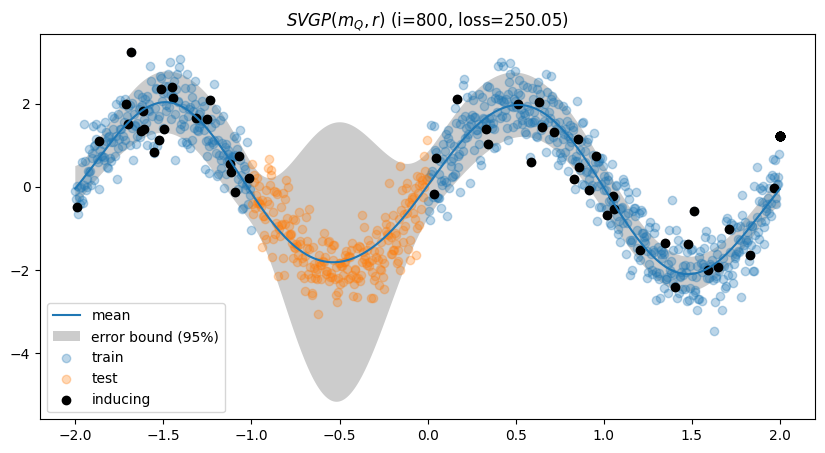

In [18]:
parameter_args = asdict(gaussian_wasserstein_distance_variable_parameters)

losses = []
opt_state = optimizer.init(parameter_args)
for i in range(number_of_iterations):
    losses.append(
        gaussian_wasserstein_distance.calculate(
            x_train,
            y_train,
            x_train,
            x_train.shape[0],
            asdict(gaussian_wasserstein_distance_frozen_parameters),
            parameter_args,
        ).item()
    )
    if i % 200 == 0:
        trained_variational_kernel_parameters = (
            GaussianWassersteinDistanceVariableParameters(**parameter_args)
        )
        loss = np.round(
            gaussian_wasserstein_distance.calculate(
                x_train,
                y_train,
                x_train,
                x_train.shape[0],
                asdict(gaussian_wasserstein_distance_frozen_parameters),
                parameter_args,
            ).item(),
            2,
        )
        trained_svgp_parameters = svgp.Parameters(
            log_sigma=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_p_log_sigma,
            kernel=trained_variational_kernel_parameters.gaussian_measure_q_kernel,
            mean=trained_variational_kernel_parameters.gaussian_measure_q_mean,
            beta=trained_variational_kernel_parameters.gaussian_measure_q_beta,
        )
        mean, covariance = svgp.mean_and_covariance(
            x, **asdict(trained_svgp_parameters)
        )
        plt.figure(figsize=(10, 5))
        plt.plot(x.reshape(-1), mean, label="mean")
        stdev = np.sqrt(np.diag(covariance))
        plt.fill_between(
            x.reshape(-1),
            (mean - 1.96 * stdev).reshape(-1),
            (mean + 1.96 * stdev).reshape(-1),
            facecolor=(0.8, 0.8, 0.8),
            label="error bound (95%)",
        )
        plt.title(f"$SVGP(m_Q, r)$ ({i=}, {loss=})")
        plt.scatter(x_train, y_train, label="train", alpha=0.3)
        plt.scatter(x_test, y_test, label="test", alpha=0.3)
        plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
        plt.legend()
        plt.show()

    gradients = jax.grad(
        lambda parameter_args: gaussian_wasserstein_distance.calculate(
            x_train,
            y_train,
            x_train,
            x_train.shape[0],
            asdict(gaussian_wasserstein_distance_frozen_parameters),
            parameter_args,
        )
    )(parameter_args)
    updates, opt_state = optimizer.update(gradients, opt_state)
    parameter_args = optax.apply_updates(parameter_args, updates)

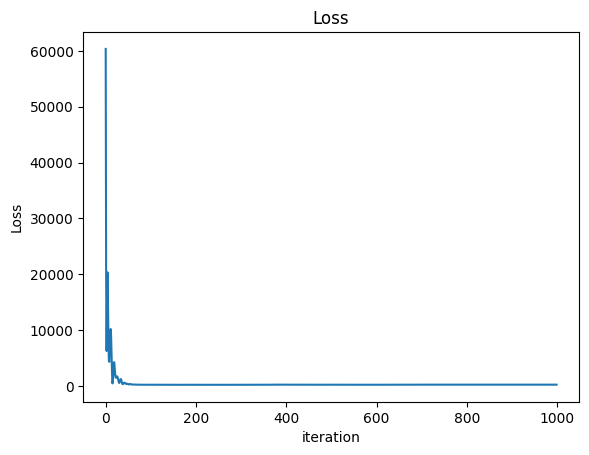

In [19]:
plt.title("Loss")
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.plot(losses)

In [20]:
trained_variational_kernel_parameters = GaussianWassersteinDistanceVariableParameters(
    **parameter_args
)
trained_svgp_parameters = svgp.Parameters(
    log_sigma=gaussian_wasserstein_distance_frozen_parameters.gaussian_measure_p_log_sigma,
    kernel=trained_variational_kernel_parameters.gaussian_measure_q_kernel,
    mean=trained_variational_kernel_parameters.gaussian_measure_q_mean,
    beta=trained_variational_kernel_parameters.gaussian_measure_q_beta,
)

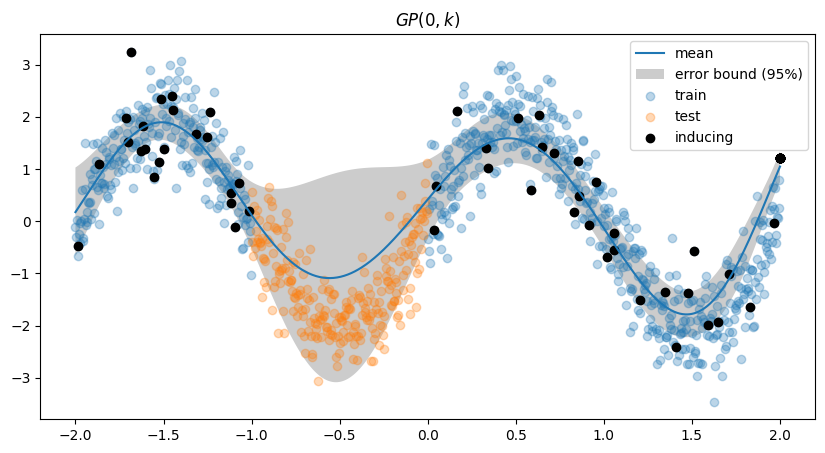

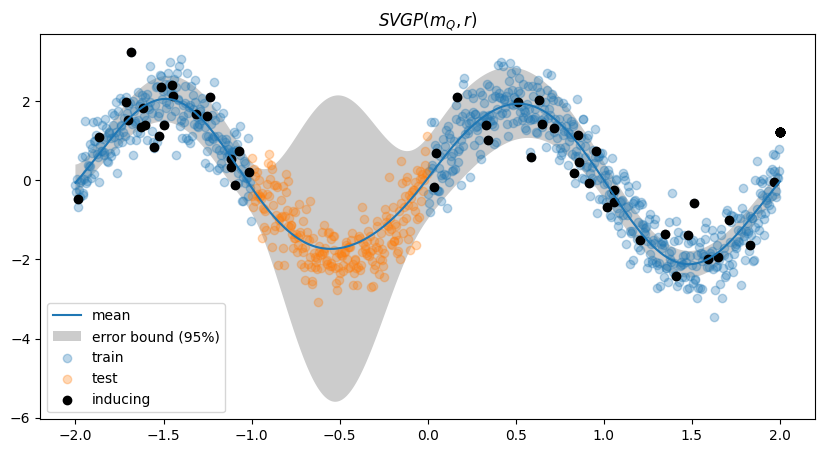

In [21]:
mean, covariance = gaussian_process.mean_and_covariance(
    x, **asdict(gaussian_process_parameters)
)
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$GP(0, k)$")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

mean, covariance = svgp.mean_and_covariance(x, **asdict(trained_svgp_parameters))
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("$SVGP(m_Q, r)$")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()